## Mean / Median imputation

Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a **complete dataset** that can be used to train machine learning models.

Mean / median imputation consists of replacing all occurrences of missing values (NA) within a variable by the mean (if the variable has a Gaussian distribution) or median (if the variable has a skewed distribution).

**Note the following**:

- If a variable is normally distributed, the mean, median and mode, are approximately the same. Therefore, replacing missing values by the mean and the median are equivalent. Replacing missing data by the mode is not common practice for  numerical variables.
- If the variable is skewed, the mean is biased by the values at the far end of the distribution. Therefore, the median is a better representation of the majority of the values in the variable.
- For discrete variables casted as 'int' (to save memory), the mean may not be an integer, therefore the whole variable will be re-casted as 'float'. In order to avoid this behaviour, we can replace NA with the median instead. The median will inevitably be an integer / discrete value as well.


### Which variables can I impute with Mean / Median Imputation?

The mean and median can only be calculated on numerical variables, therefore these methods are suitable for continuous and discrete numerical variables only.


### Assumptions

- Data is missing completely at random (MCAR)
- The missing observations, most likely look like the majority of the observations in the variable (aka, the mean / median)

If data is missing completely at random, then it is fair to assume that the missing values, are most likely very close to the value of the mean or the median of the distribution, as these represent the most frequent / average observation.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)

### Limitations

- Distortion of the original variable distribution
- Distortion of the original variance
- Distortion of the covariance with the remaining variables of the dataset

When replacing NA with the mean or median, the variance of the variable will be distorted if the number of NA is big respect to the total number of observations, leading to underestimation of the variance.

In addition, estimates of covariance and correlations with other variables in the dataset may also be affected. Mean / median imputation may alter intrinsic correlations since the mean / median value that now replaces the missing data will not necessarily preserve the relation with the remaining variables.

Finally, concentrating all missing values at the mean / median value, may lead to observations that are common occurrences in the distribution, to be picked up as outliers.


### When to use mean / median imputation?

- Data is missing completely at random
- No more than 5% of the variable contains missing data

Although in theory, the above conditions should be met to minimise the impact of this imputation technique, in practice, mean / median imputation is very commonly used, even in those cases when data is not MCAR and there are a lot of missing values. The reason behind this, is the simplicity of the technique.


### Final note

Replacement of NA with mean / median is widely used in the data science community and in various data science competitions. See for example the winning solution of the KDD 2009 cup: ["Winning the KDD Cup Orange Challenge with Ensemble Selection"]( http://www.mtome.com/Publications/CiML/CiML-v3-book.pdf).

Typically, mean / median imputation is done together with adding a binary "missing indicator" variable to capture those observations where the data was missing (see lecture "Missing Indicator"), thus covering 2 angles: if the data was missing completely at random, this would be captured by the mean /median imputation, and if it wasn't this would be captured by the additional "missing indicator" variable. Both methods are extremely straight forward to implement, and therefore are a top choice in data science competitions.


We will perform mean and median imputation using pandas on the auto-mpg Datasets.


Dataset Relevant Information:
This dataset is a slightly modified version of the dataset provided in
the StatLib library.  In line with the use by Ross Quinlan (1993) in
predicting the attribute "mpg"

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split the datasets
from sklearn.model_selection import train_test_split

# to show all the columns of the dataframe in the notebook
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv('C:\\Users\\gusal\\machine learning\\Feature engineering\\auto-mpg.data_gen.csv')

In [3]:
data.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,NaN,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,NaN,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,NaN,10.5,70,1,ford torino


In [4]:
data.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
model year        int64
origin            int64
car name         object
dtype: object

In [5]:
# let's look at the percentage of NA

data.isnull().mean()

mpg             0.000000
cylinders       0.000000
displacement    0.000000
horsepower      0.015075
weight          0.022613
acceleration    0.082915
model year      0.000000
origin          0.000000
car name        0.000000
dtype: float64

The variables with missing data are:horsepower, wight and acceleration


### Imputation important

Imputation should be done over the training set, and then propagated to the test set. This means that the mean / median to be used to fill missing values both in train and test set, should be extracted from the train set only. And this is to avoid overfitting.

In [6]:
inputs = data.drop(['mpg'], axis = 1)

In [7]:
target = data['mpg']

In [8]:
inputs.isnull().sum()

cylinders        0
displacement     0
horsepower       6
weight           9
acceleration    33
model year       0
origin           0
car name         0
dtype: int64

In [9]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    inputs,  # predictors
    target,  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((278, 8), (120, 8))

In [10]:
# Let's explore the missing data in the train set
# the percentages should be fairly similar to those
# of the whole dataset

X_train.isnull().mean()

cylinders       0.000000
displacement    0.000000
horsepower      0.017986
weight          0.021583
acceleration    0.086331
model year      0.000000
origin          0.000000
car name        0.000000
dtype: float64

In [11]:
X_train.shape

(278, 8)

In [12]:
X_train.isnull().sum()

cylinders        0
displacement     0
horsepower       5
weight           6
acceleration    24
model year       0
origin           0
car name         0
dtype: int64

In [13]:
# let's make a function to fill missing values with the mean or median:
# the variable takes the dataframe, the variable, and the value of the
# mean or median
# and returns the variable with the filled na


def impute_na(df, variable, mean_median):

    return df[variable].fillna(mean_median)

In [14]:
# calculate the median 
median_hp = X_train.horsepower.median()
median_we = X_train.weight.median()
median_acc = X_train.acceleration.median()

In [15]:
# calculate the mean

mean_hp = X_train.horsepower.mean()
mean_acc = X_train.acceleration.mean()
mean_we = X_train.weight.mean()

In [16]:
print(mean_hp, mean_we, mean_acc)

104.55311355311355 2981.235294117647 15.683070866141724


In [17]:
print(median_hp, median_we, median_acc)

95.0 2845.0 15.5


In [18]:
# create a new variable with the missing values replaced
# using the function we created above

# first replace with the median
X_train['horsepower_median'] = impute_na(X_train, 'horsepower', median_hp)

# now replace with the mean
X_train['horsepower_mean'] = impute_na(X_train, 'horsepower', mean_hp)

# the mean contains many decimals, so I round to 1
# using the round function from numpy
X_train['horsepower_mean'] = np.round(X_train['horsepower_mean'], 1)


C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

In [19]:
X_train['weight_median'] = impute_na(X_train, 'weight', median_we)

# now replace with the mean
X_train['weight_mean'] = impute_na(X_train, 'weight', mean_we)

# the mean contains many decimals, so I round to 1
# using the round function from numpy
X_train['Aweight_mean'] = np.round(X_train['weight_mean'], 1)


C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [20]:
X_train['acceleration_median'] = impute_na(X_train, 'acceleration', median_acc)

# now replace with the mean
X_train['acceleration_mean'] = impute_na(X_train, 'acceleration', mean_acc)

# the mean contains many decimals, so I round to 1
# using the round function from numpy
X_train['acceleration_mean'] = np.round(X_train['acceleration_mean'], 1)



C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\gusal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

Finding the rows with null values

In [21]:
df1 = X_train[X_train.isna().any(axis=1)]

In [22]:
df1

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,horsepower_median,horsepower_mean,weight_median,weight_mean,Aweight_mean,acceleration_median,acceleration_mean
230,8,350.0,170.0,4165.0,NaN,77,1,chevrolet monte carlo landau,170.0,170.0,4165.0,4165.000000,4165.0,15.5,15.7
66,8,304.0,150.0,3672.0,NaN,72,1,amc ambassador sst,150.0,150.0,3672.0,3672.000000,3672.0,15.5,15.7
103,8,400.0,150.0,4997.0,NaN,73,1,chevrolet impala,150.0,150.0,4997.0,4997.000000,4997.0,15.5,15.7
112,4,122.0,85.0,2310.0,NaN,73,1,ford pinto,85.0,85.0,2310.0,2310.000000,2310.0,15.5,15.7
229,8,400.0,180.0,4220.0,NaN,77,1,pontiac grand prix lj,180.0,180.0,4220.0,4220.000000,4220.0,15.5,15.7
126,6,200.0,NaN,2875.0,NaN,74,1,ford maverick,95.0,104.6,2875.0,2875.000000,2875.0,15.5,15.7
85,8,350.0,175.0,NaN,13.0,73,1,buick century 350,175.0,175.0,2845.0,2981.235294,2981.2,13.0,13.0
284,6,225.0,110.0,3360.0,NaN,79,1,dodge aspen 6,110.0,110.0,3360.0,3360.000000,3360.0,15.5,15.7
2,8,318.0,150.0,3436.0,NaN,70,1,plymouth satellite,150.0,150.0,3436.0,3436.000000,3436.0,15.5,15.7
374,4,151.0,NaN,3035.0,NaN,82,1,amc concord dl,95.0,104.6,3035.0,3035.000000,3035.0,15.5,15.7


In [23]:
# we can see a change in the variance after mean / median imputation

print('Original variable variance: ', X_train['horsepower'].var())
print('Variance after median imputation: ', X_train['horsepower_median'].var())
print('Variance after mean imputation: ', X_train['horsepower_mean'].var())

Original variable variance:  1380.6524994613228
Variance after median imputation:  1357.3486741292886
Variance after mean imputation:  1355.7310131678048


In [24]:
# we can see a change in the variance after mean / median imputation

print('Original variable variance: ', X_train['weight'].var())
print('Variance after median imputation: ', X_train['weight_median'].var())
print('Variance after mean imputation: ', X_train['weight_mean'].var())

Original variable variance:  724621.5901888431
Variance after median imputation:  709319.1617796009
Variance after mean imputation:  708925.8156721173


In [25]:
# we can see a change in the variance after mean / median imputation

print('Original variable variance: ', X_train['acceleration'].var())
print('Variance after median imputation: ', X_train['acceleration_median'].var())
print('Variance after mean imputation: ', X_train['acceleration_mean'].var())

Original variable variance:  6.74251859574866
Variance after median imputation:  6.160982390982522
Variance after mean imputation:  6.158351946601564


As expected, the variance is underestimated, because now many values are the same ==> either the mean or the median value.

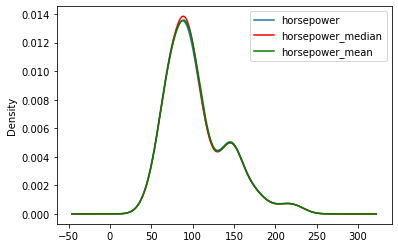

In [26]:
# we can see that the distribution has not changed too much
# with now more values accumulating a litle towards the median


fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['horsepower'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['horsepower_median'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
X_train['horsepower_mean'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

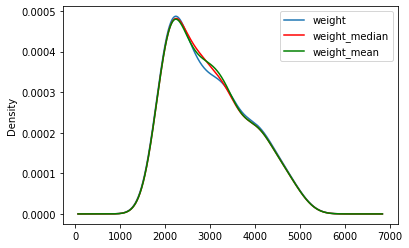

In [27]:
# we can see that the distribution has not changed too much

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['weight'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['weight_median'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
X_train['weight_mean'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

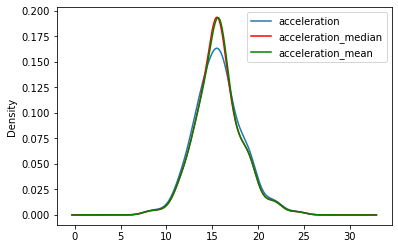

In [28]:
# we can see that the distribution has changed 
# with now more values accumulating towards the median
# or median


fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['acceleration'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['acceleration_median'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
X_train['acceleration_mean'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

As mentioned above, the mean / median imputation distorts a litle bit the original distribution of the variables. The transformed variable shows more values around the mean for acceleration values and around the median for horsepower.

**Is this important?**

It depends on the machine learning model you want to build. Linear models assume that the variables are normally distributed. Mean / median imputation may distort the original normal distribution if the % of missing data is high. Therefore the final imputed variable will no longer be normally distributed, which in turn may affect the linear model performance.

In [29]:
X_train.columns

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin', 'car name', 'horsepower_median',
       'horsepower_mean', 'weight_median', 'weight_mean', 'Aweight_mean',
       'acceleration_median', 'acceleration_mean'],
      dtype='object')

In [30]:
# we also said that mean / median imputation may affect the relationship 
# with the other variables in the dataset, let's have a look

X_train[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin', 'car name', 'horsepower_median',
       'horsepower_mean', 'weight_median', 'weight_mean', 'Aweight_mean',
       'acceleration_median', 'acceleration_mean']].cov()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,horsepower_median,horsepower_mean,weight_median,weight_mean,Aweight_mean,acceleration_median,acceleration_mean
cylinders,2.922331,166.662124,53.325603,1295.255264,-1.982959,-2.172233,-0.669013,52.551489,52.362122,1265.702491,1267.199193,1267.198805,-1.823161,-1.810039
displacement,166.662124,10507.870520,3397.293990,81341.122748,-129.919969,-138.048574,-42.075877,3345.718814,3335.923151,79514.779822,79579.221172,79579.204478,-119.374566,-118.597598
horsepower,53.325603,3397.293990,1380.652499,27422.006378,-62.909973,-55.101231,-15.172336,1380.652499,1380.652499,26785.799168,26815.691455,26815.683710,-58.028609,-57.791968
weight,1295.255264,81341.122748,27422.006378,724621.590189,-804.607320,-967.731713,-410.559583,26975.457130,26914.343868,724621.590189,724621.590189,724621.590189,-741.125591,-736.522943
acceleration,-1.982959,-129.919969,-62.909973,-804.607320,6.742519,2.780293,0.346340,-62.231048,-62.153231,-785.886561,-789.341098,-789.340203,6.742519,6.742519
model year,-2.172233,-138.048574,-55.101231,-967.731713,2.780293,26.252617,-14.915487,-54.400514,-54.105181,-909.207386,-946.770015,-946.760284,2.592602,2.534482
origin,-0.669013,-42.075877,-15.172336,-410.559583,0.346340,-14.915487,18.992910,-14.787809,-14.899010,-435.577695,-401.666596,-401.675381,0.277472,0.319926
horsepower_median,52.551489,3345.718814,1380.652499,26975.457130,-62.231048,-54.400514,-14.787809,1357.348674,1355.723035,26361.291458,26391.151200,26391.143464,-57.041986,-56.820435
horsepower_mean,52.362122,3335.923151,1380.652499,26914.343868,-62.153231,-54.105181,-14.899010,1355.723035,1355.731013,26302.011464,26331.361690,26331.354087,-56.980863,-56.748440
weight_median,1265.702491,79514.779822,26785.799168,724621.590189,-785.886561,-909.207386,-435.577695,26361.291458,26302.011464,709319.161780,708925.815672,708925.917575,-721.873703,-717.418165


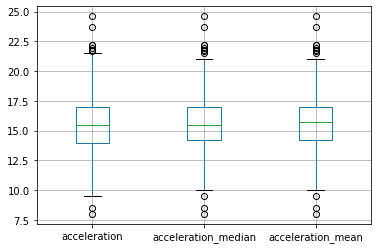

In [31]:
# Finally, the mean / median imputation may lead 
# to observations that are normal, to look like outliers

# or in other words, mean / median imputation may lead to an increase
# in the apparent number of  outliers

# Let's find out using a boxplot
X_train[['acceleration', 'acceleration_median', 'acceleration_mean']].boxplot()

From the boxplot above, we can see that after the imputation not only we have more outliers on the higher acceleration values, but we have now outliers as well for the lower values of acceleration.

**Is this important?**

If we are after true outliers, we need to keep this behaviour in mind, to make sure that we are neither masking nor creating artificial outliers with our imputation technique. In practice, we normally don't check for this behaviour at all. But I think it is important to know that is happening.
